## Import the necessary libraries

In [466]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import resample

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Load in your data from kaggle.  
By working in a kaggle kernel, you can access the data directly from the competition, as well as make your submission without downloading your output file

In [467]:
# from google.colab import files
# uploaded = files.upload()

In [468]:
# import io
# train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
# sample = pd.read_csv(io.BytesIO(uploaded['sample_submission.csv']))


# Loading the Data

In [469]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test_with_no_labels.csv')

In [470]:
df_train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [471]:
df_train.shape

(15819, 3)

# Exploratory Data Analysis

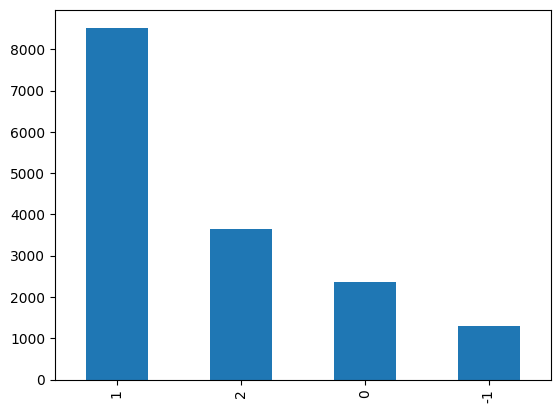

In [472]:
df_train['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [473]:
df_train['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [474]:
df_train['tweetid'].nunique()

15819

# Data Engineering

In [475]:
stopwords_list = stopwords.words('english')
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [476]:
# tfidf_vectorizer  = TfidfVectorizer(
#     max_features=8000,
#     stop_words='english',
#     min_df=2, 
#     max_df=0.5, 
#     ngram_range=(1, 2)
# )

In [477]:
# X = tfidf_vectorizer.fit_transform(df_train['message'])
# y=df_train['sentiment']

In [478]:
betterVect = CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_features=5000,
                             max_df=0.85, 
                             ngram_range=(1, 1))

In [479]:
X = betterVect.fit_transform(df_train['message'])
y=df_train['sentiment']

# Modelling

In [480]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [481]:
value_to_check = 2
encoded_value = le.transform([value_to_check])[0]
encoded_value

3

In [482]:
type_labels = list(le.classes_)
type_labels

[-1, 0, 1, 2]

In [483]:
# decoded_labels = le.inverse_transform(y_encoded)
# decoded_labels

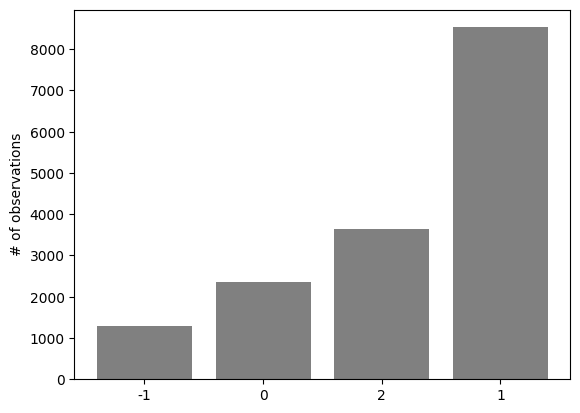

In [484]:
heights = [len(y[y == label]) for label in range(len(type_labels))]
bars = pd.DataFrame(zip(heights,le.transform(type_labels).T, type_labels), columns=['heights','labels','names'])
bars = bars.sort_values(by='heights',ascending=True)

plt.bar(range(len(bars)),bars['heights'],color='grey')
plt.xticks(range(len(bars)),bars['names'])
plt.ylabel("# of observations")
plt.show()

In [485]:
class_size = 5000

In [486]:
X = X.toarray()

In [487]:
data = np.concatenate([X, y[:,np.newaxis]], axis=1)

In [488]:
bar_label_df = bars.set_index('labels')

In [489]:
resampled_classes = []

# For each label
for label in range(len(type_labels)):
    # Get num. of observations from this class
    label_size = bar_label_df.loc[label]['heights']
    
    # If label_size < class size the upsample, else downsample
    if label_size < class_size:
        # Upsample
        label_data = data[data[:,-1] == label]
        label_resampled = resample(label_data,
                                  replace=True, # sample with replacement (we need to duplicate observations)
                                  n_samples=class_size, # number of desired samples
                                  random_state=27) # reproducible results
    else:
        # Downsample
        label_data = data[data[:,-1] == label]
        label_resampled = resample(label_data,
                                  replace=False, # sample without replacement (no need for duplicate observations)
                                  n_samples=8530, # number of desired samples
                                  random_state=27) # reproducible results
        
    resampled_classes.append(label_resampled)

In [490]:
resampled_data = np.concatenate(resampled_classes, axis=0)

In [491]:
resampled_data.shape

(23530, 5001)

In [492]:
X_resampled = resampled_data[:,:-1]

In [493]:
y_resampled = resampled_data[:,-1]

In [494]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [495]:
class_weights = {}
total_samples = len(y_train)
unique_classes = np.unique(y_train)
for c in unique_classes:
    class_count = len(y_train[y_train == c])
    class_weights[c] = total_samples / (len(unique_classes) * class_count)

In [496]:
class_weights

{0: 1.1809284818067753,
 1: 1.1729810568295114,
 2: 0.6897259270115785,
 3: 1.1753246753246753}

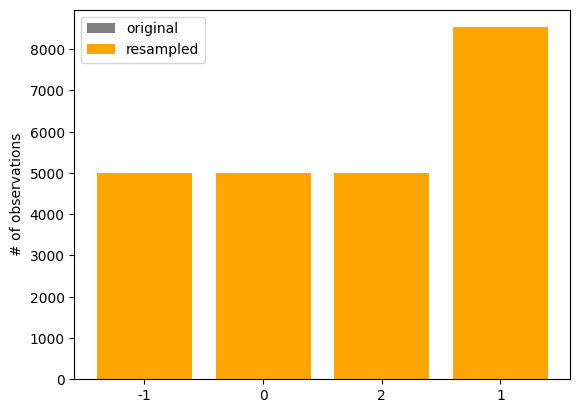

In [497]:
heights = [len(y_resampled[y_resampled == label]) for label in range(len(type_labels))]
bars_resampled = pd.DataFrame(zip(heights,le.transform(type_labels).T, type_labels), columns=['heights','labels','names'])
bars_resampled = bars_resampled.sort_values(by='heights',ascending=True)

plt.bar(range(len(bars)),bars['heights'],color='grey')
plt.bar(range(len(bars_resampled)),bars_resampled['heights'],color='orange')
plt.xticks(range(len(bars)),bars['names'])
plt.ylabel("# of observations")
plt.legend(['original','resampled'])
plt.show()

In [498]:
class_weights = {0:3, 1:1, 2:10, 3:1}


In [499]:
custom_scorer = make_scorer(f1_score, average='weighted')

In [500]:
params_grid = {
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'n_estimators': 200
    }

In [506]:
# rf_model = RandomForestClassifier(min_samples_leaf=1,min_samples_split=2, n_estimators=200, random_state=42, class_weight=class_weights)
rf_model = RandomForestClassifier(min_samples_leaf=1,min_samples_split=2, n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
rf_model.fit(X_train, y_train)

In [502]:
cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, scoring=custom_scorer)

In [503]:
print("Cross-Validation Scores:", cv_scores)
print(f"Mean F1-Score: {np.mean(cv_scores):.2f}")

Cross-Validation Scores: [0.85778326 0.86694872 0.85801931 0.86196545 0.86064041]
Mean F1-Score: 0.86


# Model Perfomance

In [452]:
y_pred = rf_model.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))

0.8847891747605925


In [453]:
type_labels

[-1, 0, 1, 2]

In [454]:
text_array = [str(num) for num in type_labels]

In [455]:
report = classification_report(y_test, y_pred, target_names=text_array)
print(report)

              precision    recall  f1-score   support

          -1       0.94      0.97      0.95      1015
           0       0.81      0.93      0.87       988
           1       0.90      0.79      0.84      1707
           2       0.87      0.89      0.88       996

    accuracy                           0.88      4706
   macro avg       0.88      0.90      0.88      4706
weighted avg       0.88      0.88      0.88      4706



In [456]:
def confusionmatrix(df, labels):
    # Calculate the normalized confusion matrix
    normalized_confusion = df.astype('float') / df.sum(axis=1)[:, np.newaxis]

    # Display the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(normalized_confusion, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()

    for i in range(normalized_confusion.shape[0]):
        for j in range(normalized_confusion.shape[1]):
            plt.text(j, i, format(normalized_confusion[i, j], '.2f'),
                    horizontalalignment="center",
                    color="white" if normalized_confusion[i, j] > 0.5 else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

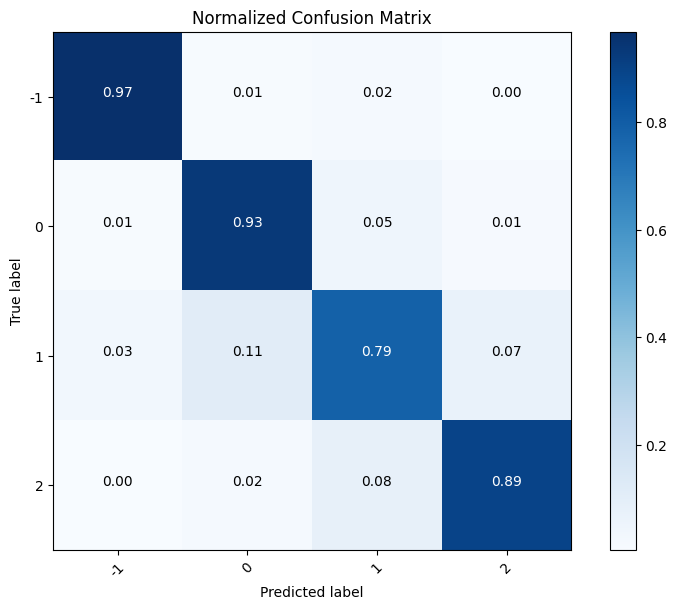

In [457]:
confusion = confusion_matrix(y_test, y_pred)
confusionmatrix(confusion, labels=type_labels)

In [419]:
# feature_importances = rf_model.feature_importances_
# feature_importances

array([3.28741341e-04, 5.50756354e-04, 9.39687273e-05, ...,
       2.66795727e-05, 2.79024648e-05, 5.00788381e-05])

In [420]:
# csv_file = 'feature_importances.csv'
# np.savetxt(csv_file, feature_importances, delimiter=',', fmt='%d')

### Hyperparameter tuning

In [333]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer

In [113]:
rf_classifier = RandomForestClassifier(random_state=42)

In [114]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required in a leaf node
}

In [116]:
f1_macro_scorer = make_scorer(f1_score, average='macro')

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring=f1_macro_scorer)


In [117]:
# Fit the GridSearch to your data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(f1_score, average=macro))

In [118]:
# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [119]:
# Evaluate the best model on the test set
y_pred_hyp = best_estimator.predict(X_test)

In [120]:
print("Best Parameters:", best_params)
print(classification_report(y_test, y_pred_hyp))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       995
         1.0       0.85      0.89      0.87      1024
         2.0       0.85      0.64      0.73      1004
         3.0       0.78      0.94      0.85       977

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.84      4000
weighted avg       0.85      0.85      0.84      4000



### Test data

In [504]:
test_messages = df_test['message']
test_vect = betterVect.transform(test_messages)

In [275]:
y_pred_test = rf_model.predict(test_vect)

In [505]:
y_pred = rf_model.predict(test_vect)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [460]:
y_pred

array([2, 2, 2, ..., 2, 1, 1], dtype=int64)

In [278]:
y_pred_test

array([2., 2., 2., ..., 2., 1., 1.])

In [279]:
y_pred_test = y_pred_test.astype(int)
y_pred_test

array([2, 2, 2, ..., 2, 1, 1])

In [461]:
y_pred = y_pred.astype(int)
y_pred

array([2, 2, 2, ..., 2, 1, 1])

In [281]:
y_pred_reverse = le.inverse_transform(y_pred_test)
y_pred_reverse

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [462]:
y_pred_reverse = le.inverse_transform(y_pred)
y_pred_reverse

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [463]:
df_test['sentiment'] = y_pred_reverse
# df_test['sentiment'] = df_test['sentiment'].astype(int)

In [464]:
df_test.head()

,message,tweetid,sentiment
0,Europe will now be looking to China to make su...,169760,1
1,Combine this with the polling of staffers re c...,35326,1
2,"The scary, unimpeachable evidence that climate...",224985,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,1
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,0


In [465]:
df_test[['tweetid', 'sentiment']].to_csv('mbongenomzila_submission.csv', index=False)